In [1]:
import os
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

from torchscan import summary

import PIL
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Python38\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


# Utils

In [2]:
def get_pil_image(dirname, path):
    return PIL.Image.open(os.path.join(f'../input/{dirname}', path))

def get_image(dirname, path):
    return np.array(get_pil_image(dirname, path))

def image_histplot(img, **kwargs):
    if not 'figsize' in kwargs: kwargs['figsize'] = (12, 3)
    fig, axes = plt.subplots(1, 4, **kwargs)
    plt.tight_layout()
    axes[0].imshow(img)
    for i in range(3):
        axes[1+i].set_yticks([])
        sns.histplot(img[:,:,i].flatten() / 255, ax=axes[1+i], color="rgb"[i], alpha=0.33)
    plt.show()

def image_gridplot(images, rows=None, cols=None, transform=None, **kwagrs):
    batch_size = len(images)
    if rows == None and cols == None:
        cols = min(6, batch_size)
        rows = math.ceil(batch_size / cols)
    elif rows == None:
        rows = math.ceil(batch_size / cols)
    elif cols == None:
        cols = math.ceil(batch_size / rows)
    if not 'figsize' in kwagrs: kwagrs['figsize'] = (3 * cols, 3 * rows)
    fig = plt.figure(**kwagrs)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.1)
    for ax, im in zip(grid, images):
        ax.axis('off')
        if transform != None: im = transform(im)
        ax.imshow(im)
    plt.show()

class ImageConv:
    def tensor2np(tensor):
        return tensor.permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8)

    def np2tensor(nparr):
#         return torch.tensor(nparr).to(Hypers.device).permute(2, 0, 1).float()
        return torch.tensor(nparr).permute(2, 0, 1).float()
    
    def to_plt(x):
        if type(x) == torch.Tensor:
            return ImageConv.tensor2np(x).astype(np.uint8)
        return x.astype(np.uint8)

# Configuration

In [3]:
class Hypers:
    verbose = True

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    image_size = (224, 224)

    max_epoches = 5
    batch_size = 128
    learning_rate = 1e-3
    optimizer = torch.optim.Adam

    patience = 5


# CUDA set-up
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Dataset

In [4]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

inv_transform = T.Compose([
    T.Normalize((-mean / std).tolist(), (1.0 / std).tolist()),
    T.ToPILImage(),
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(trainset)
print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.5 0.5 0.5])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.5 0.5 0.5])
           )


In [6]:
images, labels = next(iter(trainloader))

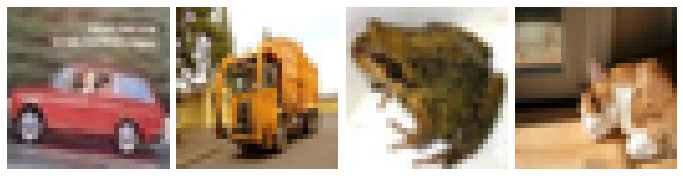

In [7]:
image_gridplot(images, transform=inv_transform)

# Define Model

In [8]:
model = torchvision.models.densenet201(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(1920, 10)
)
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True
summary(model, (3, 224, 224))

__________________________________________________________________________
Layer                       Type           Output Shape          Param #  
densenet                    DenseNet       (-1, 10)              0        
├─features                  Sequential     (-1, 1920, 7, 7)      0        
|    └─conv0                Conv2d         (-1, 64, 112, 112)    9,408    
|    └─norm0                BatchNorm2d    (-1, 64, 112, 112)    257      
|    └─relu0                ReLU           (-1, 64, 112, 112)    0        
|    └─pool0                MaxPool2d      (-1, 64, 56, 56)      0        
|    └─denseblock1          _DenseBlock    (-1, 256, 56, 56)     0        
|    |    └─denselayer1     _DenseLayer    (-1, 32, 56, 56)      0        
|    |    |    └─norm1      BatchNorm2d    (-1, 64, 56, 56)      257      
|    |    |    └─relu1      ReLU           (-1, 64, 56, 56)      0        
|    |    |    └─conv1      Conv2d         (-1, 128, 56, 56)     8,192    
|    |    |    └─norm2   

c:\users\joona\documents\2022\gan\torch-scan\torchscan\process\memory.py:31: UserWarning: raised: could not convert string to float: ''. Assuming no GPU is available.
  warnings.warn(f"raised: {e}. Assuming no GPU is available.")


## K-Fold Loader

In [9]:
from torch.utils.data import SubsetRandomSampler

class KFoldDataLoader:
    def __init__(self,
        dataset,
        batch_size=16,
        num_workers=0,
        verbose=False,
        debug=False,
        **kwargs
    ):
        self.dataset = dataset
        self.kwargs = kwargs
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.verbose = verbose
        self.debug = debug
        self.reset(**kwargs)

    def reset(self, **kwargs):
        self.generator = StratifiedKFold(**kwargs)
        self.splits = list(self.generator.split(self.dataset.data, self.dataset.targets))
        self.current = 0

    def fetch(self):
        if self.current >= self.generator.get_n_splits():
            self.reset(**self.kwargs)
        train_idx, valid_idx = self.splits[self.current]
        if self.debug:
            rate = 0.01 # 10%
            t_count = int(len(train_idx) * rate)
            v_count = int(len(valid_idx) * rate)
            train_idx = train_idx[::len(train_idx)//t_count]
            valid_idx = valid_idx[::len(valid_idx)//v_count]
        if self.verbose:
            print('Image count: {} trains, {} valids'.format(len(train_idx), len(valid_idx)))
        self.current += 1
        train_subsampler = SubsetRandomSampler(train_idx)
        valid_subsampler = SubsetRandomSampler(valid_idx)
        train_loader = DataLoader(self.dataset, batch_size=self.batch_size, sampler=train_subsampler, num_workers=self.num_workers)
        valid_loader = DataLoader(self.dataset, batch_size=self.batch_size, sampler=valid_subsampler, num_workers=self.num_workers)
        return train_loader, valid_loader

# Create Dataset and Fold to train

In [10]:
dataloader_kfold = KFoldDataLoader(trainset, batch_size=Hypers.batch_size, n_splits=4, shuffle=True, num_workers=4, debug=True)
# train_loader, valid_loader = dataloader_kfold.fetch()

# Train

In [11]:
# Clear CUDA memory
# torch.cuda.empty_cache()

In [12]:
print('Parameters to learn:')
parameters_learn = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        parameters_learn.append(param)
        print('    ',name)

Parameters to learn:
     classifier.0.weight
     classifier.0.bias


In [13]:
import jmt2 as jmt
import jmt2.callback as callback

args = {
    'accelerator': Hypers.device,
    'loss_function': nn.CrossEntropyLoss(),
    'optimizer': Hypers.optimizer(parameters_learn, lr=Hypers.learning_rate),
    'min_epochs': 2,
    'max_epochs': Hypers.max_epoches,
    'progress': True,
    'verbose': Hypers.verbose,
    'callbacks': [
        callback.EarlyStopCallback(
            patience=Hypers.patience,
            min_delta=-1, # gradient to be added
            max_seconds=5 * 3600,
            verbose=True),
        callback.CheckpointCallback(
            name='model.pth',
            min_delta=0.05,
            load_from_checkpoint=True,
            verbose=True),
        callback.ShowGraphCallback(
            verbose=True,
        ),
    ]
}

print(args)

trainer = jmt.Trainer(**args)
trainer.fit(model, dataloader_kfold.fetch)

Output()

{'accelerator': device(type='cuda', index=0), 'loss_function': CrossEntropyLoss(), 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), 'min_epochs': 2, 'max_epochs': 5, 'progress': True, 'verbose': True, 'callbacks': [<jmt2.callback.EalryStopCallback.EarlyStopCallback object at 0x00000180E0F46400>, <jmt2.callback.CheckpointCallback.CheckpointCallback object at 0x00000180E0F46A60>, <jmt2.callback.ShowGraphCallback.ShowGraphCallback object at 0x00000180E0F46430>]}


0it [00:00, ?it/s]

[CheckpointCallback] model loaded from ./model.pth
[Trainer(epoch=1)] 0:00:30.851612 train/valid loss: 1.44183/1.42564
[CheckpointCallback(./model.pth)] update best: 1.4337360660235086
[Trainer(epoch=2)] 0:00:56.161463 train/valid loss: 1.29741/1.37360
[CheckpointCallback(./model.pth)] update best: 1.335508624712626
[Trainer(epoch=3)] 0:01:23.599463 train/valid loss: 1.34942/1.35816
[Trainer(epoch=4)] 0:01:47.902526 train/valid loss: 1.32381/1.47109
[Trainer(epoch=5)] 0:02:11.522647 train/valid loss: 1.28409/1.37997


# Visualization

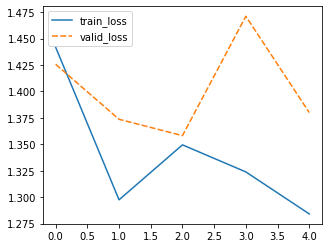

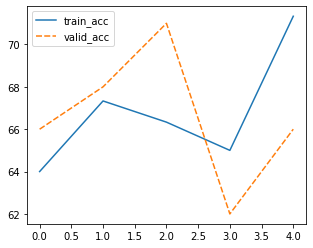

In [14]:
logging_df = pd.DataFrame(trainer.log)

plt.figure(figsize=(5, 4))
sns.lineplot(data=logging_df[['train_loss', 'valid_loss']])
plt.show()

plt.figure(figsize=(5, 4))
sns.lineplot(data=logging_df[['train_acc', 'valid_acc']])
plt.show()